# Imports #

In [1]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead
import cv2
import matplotlib.pyplot as plt
import os
import json
import random
import numpy as np
import seaborn as sns
import pandas as pd

# Visualizzazione dati training #

In [2]:
def find_history_file():
    print("Cerco history.json nella cartella di input...")
    for root, dirs, files in os.walk('/kaggle/input'):
        for file in files:
            if file == 'history.json':
                full_path = os.path.join(root, file)
                print(f" Trovato: {full_path}")
                return full_path
    print("File 'history.json' non trovato. Assicurati di aver aggiunto l'output del training (Add Data -> Your Work).")
    return None

json_path = find_history_file()

Cerco history.json nella cartella di input...
 Trovato: /kaggle/input/punto4/history.json


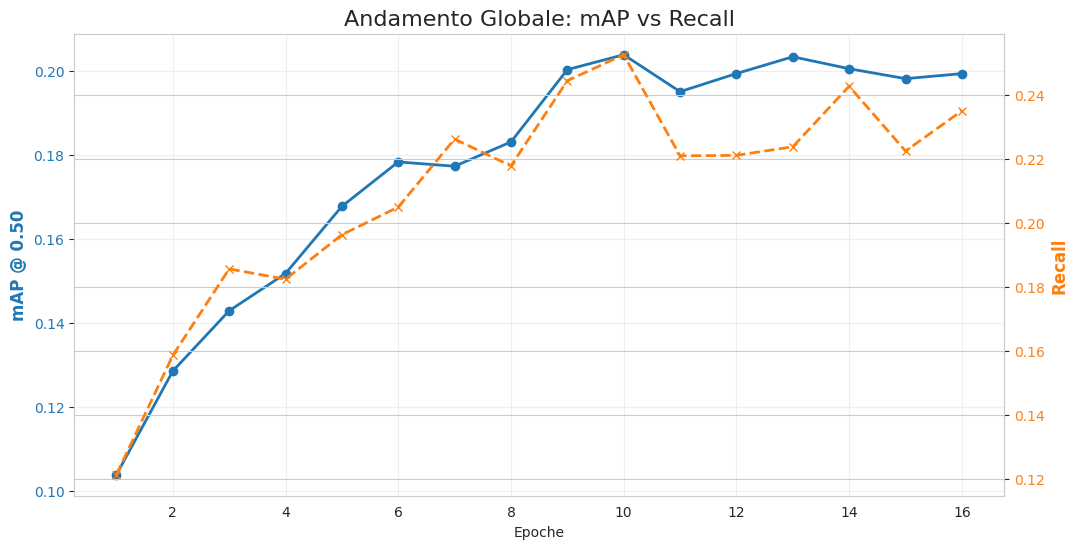

⚠️ Attenzione: Nessun dettaglio per classe trovato nella history.
Dati per classe non disponibili.
Dati per classe non disponibili.


In [4]:
if json_path:
    with open(json_path, 'r') as f:
        history = json.load(f)

# Imposto lo stile
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

def plot_training_metrics(history):
    """
    Funzione Master per visualizzare tutte le metriche.
    """
    epochs = range(1, len(history['train_loss']) + 1)
    
    # -------------------------------------------------------
    # 1. GRAFICO GLOBALE: mAP @ 50 e RECALL
    # -------------------------------------------------------
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # mAP (Asse Y sinistro)
    color = 'tab:blue'
    ax1.set_xlabel('Epoche')
    ax1.set_ylabel('mAP @ 0.50', color=color, fontsize=12, fontweight='bold')
    ax1.plot(epochs, history['val_map_50'], color=color, linewidth=2, marker='o', label='mAP @ 50')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, alpha=0.3)

    # Recall (Asse Y destro)
    ax2 = ax1.twinx()  
    color = 'tab:orange'
    ax2.set_ylabel('Recall', color=color, fontsize=12, fontweight='bold')
    ax2.plot(epochs, history['val_recall'], color=color, linewidth=2, linestyle='--', marker='x', label='Recall')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Andamento Globale: mAP vs Recall', fontsize=16)
    plt.show()

    # -------------------------------------------------------
    # 2. GRAFICO "SPAGHETTI": TUTTE LE CLASSI INSIEME
    # -------------------------------------------------------
    # Trasformiamo la lista di dizionari in un DataFrame pandas per facilità
    if 'class_aps' in history and len(history['class_aps']) > 0:
        df_classes = pd.DataFrame(history['class_aps'])
        df_classes.index = epochs  # Indice = Epoche

        plt.figure(figsize=(16, 10))
        
        # Plot di tutte le colonne (classi)
        # Usiamo una colormap per distinguere le linee
        colormap = plt.cm.nipy_spectral
        colors = [colormap(i) for i in np.linspace(0, 1, len(df_classes.columns))]
        ax = plt.gca()
        ax.set_prop_cycle('color', colors)

        for column in df_classes.columns:
            # Filtro opzionale: Disegna solo se la classe ha raggiunto almeno > 0.05
            if df_classes[column].max() > 0.05:
                plt.plot(df_classes.index, df_classes[column], alpha=0.6, linewidth=1.5, label=column)
            else:
                # Disegna in grigio chiaro le classi "morte"
                plt.plot(df_classes.index, df_classes[column], color='lightgray', alpha=0.3, linewidth=0.5)

        plt.title('Evoluzione mAP di TUTTE le Classi', fontsize=16)
        plt.xlabel('Epoca')
        plt.ylabel('AP per Classe')
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, ncol=2, fontsize='small')
        plt.tight_layout()
        plt.show()

        # -------------------------------------------------------
        # 3. TOP & FLOP (Bar Chart all'ultima epoca)
        # -------------------------------------------------------
        last_epoch_data = df_classes.iloc[-1].sort_values(ascending=False)
        
        # Prendiamo le migliori 15 e le peggiori 10
        top_15 = last_epoch_data.head(15)
        # Filtriamo le flop per mostrare solo quelle che sono a 0
        flop_10 = last_epoch_data[last_epoch_data == 0].head(10) 

        plt.figure(figsize=(14, 6))
        
        # Plot Top
        plt.subplot(1, 2, 1)
        sns.barplot(x=top_15.values, y=top_15.index, palette='viridis')
        plt.title('TOP 15 Classi (Ultima Epoca)')
        plt.xlabel('mAP')

        # Plot Flop
        plt.subplot(1, 2, 2)
        if not flop_10.empty:
            sns.barplot(x=flop_10.values, y=flop_10.index, color='red')
            plt.title('Classi ANCORA A ZERO (Esempio)')
            plt.xlim(0, 0.1) # Fisso per far vedere che sono a zero
        else:
            plt.text(0.5, 0.5, "Nessuna classe a zero! Ottimo!", ha='center')
        
        plt.tight_layout()
        plt.show()

    else:
        print("⚠️ Attenzione: Nessun dettaglio per classe trovato nella history.")

# -------------------------------------------------------
# 4. FUNZIONE PER SINGOLA CLASSE
# -------------------------------------------------------
def plot_single_class_trend(history, class_name):
    """
    Visualizza l'andamento specifico di una singola classe.
    """
    if 'class_aps' not in history:
        print("Dati per classe non disponibili.")
        return

    df_classes = pd.DataFrame(history['class_aps'])
    epochs = range(1, len(history['train_loss']) + 1)
    df_classes.index = epochs

    if class_name not in df_classes.columns:
        print(f"Errore: La classe '{class_name}' non esiste nel dataset.")
        print(f"Classi disponibili: {list(df_classes.columns)[:5]} ...")
        return

    plt.figure(figsize=(10, 4))
    
    # Linea principale
    plt.plot(df_classes.index, df_classes[class_name], 
             color='crimson', linewidth=3, marker='o', label=class_name)
    
    # Riempimento area sotto la curva
    plt.fill_between(df_classes.index, df_classes[class_name], color='crimson', alpha=0.1)
    
    plt.title(f'Focus On: {class_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Epoca')
    plt.ylabel('Average Precision (AP)')
    plt.grid(True, linestyle='--')
    plt.legend()
    plt.show()

# --- ESECUZIONE ---
if 'history' in locals():
    plot_training_metrics(history)
    
    plot_single_class_trend(history, 'Small Aircraft') 
    plot_single_class_trend(history, 'Hut/Tent')
else:
    print("❌ Variabile 'history' non trovata. Carica prima il file history.json!")

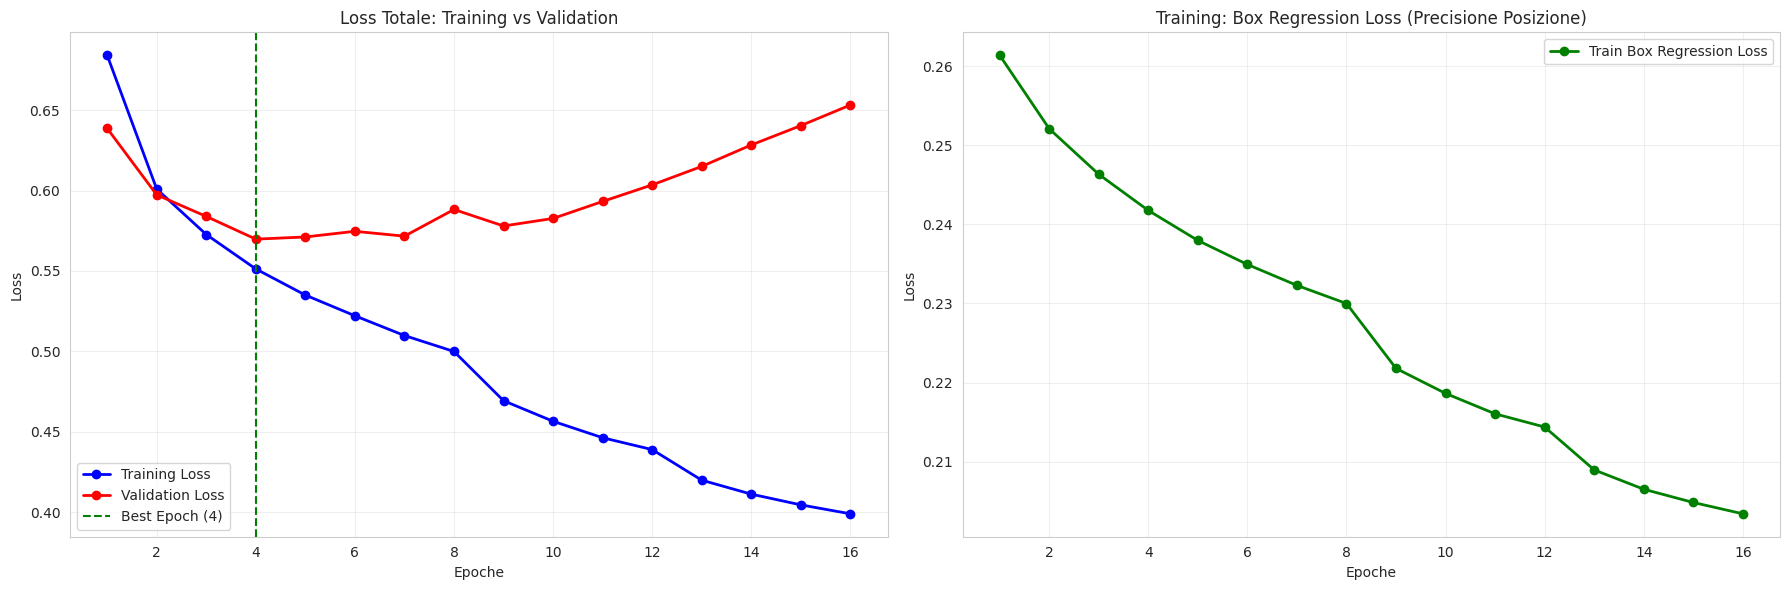


 RIEPILOGO METRICHE:
• Epoche totali addestrate: 16
• Loss Training finale:     0.3989
• Loss Validation finale:   0.6532
• Miglior Validation Loss:  0.5698 all'epoca 4


In [4]:
# CARICO E PLOTTO I DATI
if json_path:
    with open(json_path, 'r') as f:
        history = json.load(f)

    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(18, 6))


    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-o', label='Training Loss', linewidth=2)
    plt.plot(epochs, history['val_loss'], 'r-o', label='Validation Loss', linewidth=2)
    
    # Cerco il punto minimo della validation loss (Best Model teorico)
    min_val_loss = min(history['val_loss'])
    best_epoch = history['val_loss'].index(min_val_loss) + 1
    plt.axvline(x=best_epoch, color='green', linestyle='--', label=f'Best Epoch ({best_epoch})')
    
    plt.title('Loss Totale: Training vs Validation')
    plt.xlabel('Epoche')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # GRAFICO B: PRECISIONE BOX 
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_box_loss'], 'g-o', label='Train Box Regression Loss', linewidth=2)
    
    plt.title('Training: Box Regression Loss (Precisione Posizione)')
    plt.xlabel('Epoche')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # STAMPA DI RIEPILOGO 
    print(f"\n RIEPILOGO METRICHE:")
    print(f"• Epoche totali addestrate: {len(epochs)}")
    print(f"• Loss Training finale:     {history['train_loss'][-1]:.4f}")
    print(f"• Loss Validation finale:   {history['val_loss'][-1]:.4f}")
    print(f"• Miglior Validation Loss:  {min_val_loss:.4f} all'epoca {best_epoch}")

# Definizione del modello #

In [5]:
def get_maskrcnn_model(num_classes):

    model = torchvision.models.detection.maskrcnn_resnet50_fpn(
            weights="DEFAULT",
            min_size=512, # fisso la dimensione del resize automatico della rete (default 1333x800), altrimenti la rete effettua train su dimensioni diverse che dal test
            max_size=512, # analogo
            rpn_fg_iou_thresh=0.4, # considera roi se > 0.4
            rpn_bg_iou_thresh=0.2, # considera sfondo se < 0.2
        
            # aumento le proposte per essere sicuro di non perderne
            rpn_pre_nms_top_n_train=2000, 
            rpn_post_nms_top_n_train=2000,
            # ----------------------------------
        )    


    
    anchor_sizes = ((8,), (16,), (32,), (64,), (128,))
    aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
    
    # Creiamo il nuovo generatore
    rpn_anchor_generator = AnchorGenerator(
        sizes=anchor_sizes, 
        aspect_ratios=aspect_ratios
    )
    
    model.rpn.anchor_generator = rpn_anchor_generator

    in_channels = model.rpn.head.cls_logits.in_channels
    
    num_anchors = rpn_anchor_generator.num_anchors_per_location()[0]
    
    model.rpn.head = RPNHead(in_channels, num_anchors)
    
    in_features_box = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features_box, num_classes)

    model.roi_heads.mask_predictor = None # fondamentale
    
    return model

# Carico modello #

In [6]:
# carico il modello
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_maskrcnn_model(num_classes=61)
model.to(device)

model_path = '/kaggle/input/punto4/model_epoch_10.pth' 

if os.path.exists(model_path):
    print(f"Caricamento da {model_path}...")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print(" Modello caricato!")
else:
    print(f" File non trovato in {model_path}. Controlla i percorsi a destra.")


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


100%|██████████| 170M/170M [00:00<00:00, 204MB/s]  


Caricamento da /kaggle/input/punto4/model_epoch_10.pth...
 Modello caricato!


# Funzione di inferenza #

Analisi Tiled su: 371.tif
Inizio scansione a tile...
Box grezzi trovati: 512
Box finali dopo NMS: 262
Immagine salvata in: /kaggle/working/predictions/371.tif


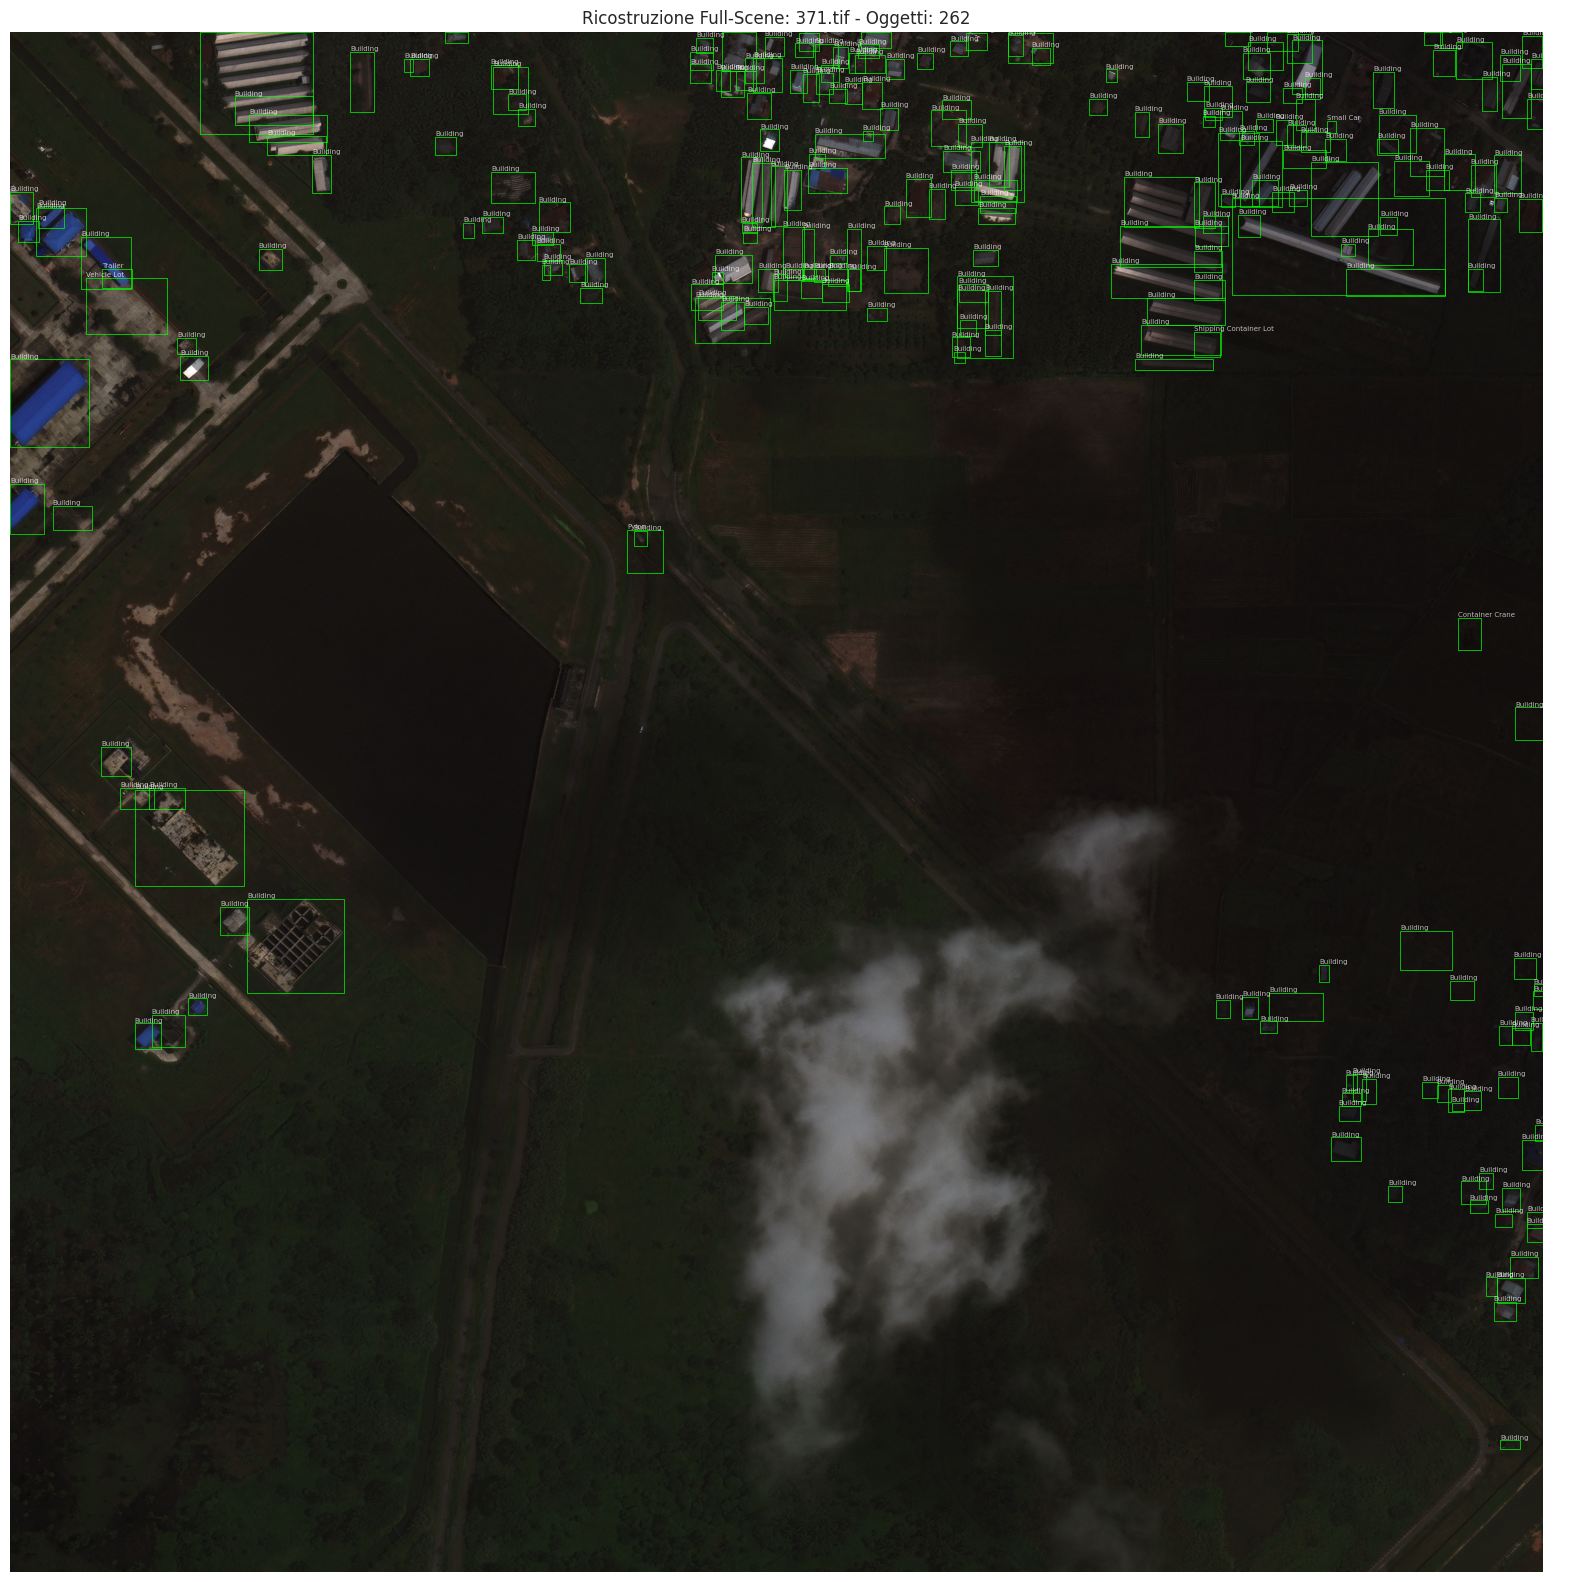

In [24]:

# --- CONFIGURAZIONE PERCORSI ---
TEST_JSON_PATH = '/kaggle/input/punto4/test_annotations.json' 
INPUT_IMAGES_DIR = '/kaggle/input/xview-dataset/train_images/train_images' 
OUTPUT_DIR = '/kaggle/working/predictions'
os.makedirs(OUTPUT_DIR, exist_ok=True)


# --- CONFIGURAZIONE TILING INFERENZA ---
TILE_SIZE = 512
STRIDE = 400  

# --- DIZIONARIO DEI NOMI ---
ID_TO_NAME = {
    1: 'Fixed-wing Aircraft', 2: 'Small Aircraft', 3: 'Cargo Plane', 4: 'Helicopter',
    5: 'Passenger Vehicle', 6: 'Small Car', 7: 'Bus', 8: 'Pickup Truck',
    9: 'Utility Truck', 10: 'Truck', 11: 'Cargo Truck', 12: 'Truck w/Box',
    13: 'Truck Tractor', 14: 'Trailer', 15: 'Truck w/Flatbed', 16: 'Truck w/Liquid',
    17: 'Crane Truck', 18: 'Railway Vehicle', 19: 'Passenger Car', 20: 'Cargo Car',
    21: 'Flat Car', 22: 'Tank Car', 23: 'Locomotive', 24: 'Maritime Vessel',
    25: 'Motorboat', 26: 'Sailboat', 27: 'Tugboat', 28: 'Barge',
    29: 'Fishing Vessel', 30: 'Ferry', 31: 'Yacht', 32: 'Container Ship',
    33: 'Oil Tanker', 34: 'Engineering Vehicle', 35: 'Tower crane', 36: 'Container Crane',
    37: 'Reach Stacker', 38: 'Straddle Carrier', 39: 'Mobile Crane', 40: 'Dump Truck',
    41: 'Haul Truck', 42: 'Scraper/Tractor', 43: 'Front loader/Bulldozer', 44: 'Excavator',
    45: 'Cement Mixer', 46: 'Ground Grader', 47: 'Hut/Tent', 48: 'Shed',
    49: 'Building', 50: 'Aircraft Hangar', 51: 'Damaged Building', 52: 'Facility',
    53: 'Construction Site', 54: 'Vehicle Lot', 55: 'Helipad', 56: 'Storage Tank', 57: 'Shipping Container Lot',
    58: 'Shipping container', 59: 'Pylon', 60: 'Tower'
}

def run_tiled_inference(model, threshold=0.3): # Threshold un po' più alta per evitare rumore
    
    # Caricamento lista immagini
    if not os.path.exists(TEST_JSON_PATH):
        print(f"Errore: Non trovo {TEST_JSON_PATH}")
        return

    with open(TEST_JSON_PATH, 'r') as f:
        test_img_names = json.load(f)
    
    # Scelta casuale
    random_img_name = random.choice(test_img_names)
    full_img_path = os.path.join(INPUT_IMAGES_DIR, random_img_name)
    
    print(f"Analisi Tiled su: {random_img_name}")
    
    if not os.path.exists(full_img_path):
        print(f"Errore: File non trovato in {full_img_path}")
        return

    # 2. Lettura immagine FULL
    full_img = cv2.imread(full_img_path)
    if full_img is None: return
    full_img_rgb = cv2.cvtColor(full_img, cv2.COLOR_BGR2RGB)
    
    h_img, w_img, _ = full_img.shape
    
    # Liste per accumulare tutti i risultati di tutti i tile
    global_boxes = []
    global_scores = []
    global_labels = []

    model.eval()
    
    print("Inizio scansione a tile...")
    
    # 3. CICLO DI TILING (Sliding Window)
    y = 0
    while y < h_img:
        x = 0
        while x < w_img:
            # Calcolo coordinate tile
            x2 = min(x + TILE_SIZE, w_img)
            y2 = min(y + TILE_SIZE, h_img)
            x1 = x2 - TILE_SIZE
            y1 = y2 - TILE_SIZE
            

            if x1 < 0: x1 = 0
            if y1 < 0: y1 = 0
            
            tile = full_img_rgb[y1:y2, x1:x2]
            
            tile_tensor = torchvision.transforms.functional.to_tensor(tile).to(device)
            with torch.no_grad():
                prediction = model([tile_tensor])[0]
            
            # Filtraggio e Traslazione Coordinate

            
            for box, score, label in zip(prediction['boxes'], prediction['scores'], prediction['labels']):
                if score > threshold:
                    # Sposta coordinate locali -> globali
                    box[0] += x1
                    box[1] += y1
                    box[2] += x1
                    box[3] += y1
                    
                    global_boxes.append(box)
                    global_scores.append(score)
                    global_labels.append(label)
            
            # Avanzamento x
            if x2 == w_img: break # Fine riga
            x += STRIDE
            
        # Avanzamento y
        if y2 == h_img: break # Fine immagine
        y += STRIDE

    # 4. POST-PROCESSING
    if len(global_boxes) == 0:
        print("Nessun oggetto trovato.")
        plt.imshow(full_img_rgb)
        plt.show()
        return

    # Convertiamo le liste in tensori unici
    global_boxes = torch.stack(global_boxes)
    global_scores = torch.stack(global_scores)
    global_labels = torch.stack(global_labels)

    print(f"Box grezzi trovati: {len(global_boxes)}")

    # Applico NMS (Non-Maximum Suppression) per unire i duplicati delle sovrapposizioni
    keep_indices = torchvision.ops.nms(global_boxes, global_scores, iou_threshold=0.3)
    
    final_boxes = global_boxes[keep_indices]
    final_scores = global_scores[keep_indices]
    final_labels = global_labels[keep_indices]

    print(f"Box finali dopo NMS: {len(final_boxes)}")

    # VISUALIZZAZIONE FINALE
    plt.figure(figsize=(20, 20))
    plt.imshow(full_img_rgb)
    ax = plt.gca()
    
    for box, score, label in zip(final_boxes, final_scores, final_labels):
        x1, y1, x2, y2 = box.cpu().numpy()
        class_id = label.item()
        class_name = ID_TO_NAME.get(class_id, f"ID {class_id}")
        
        rect = plt.Rectangle(
            (x1, y1),
            x2 - x1,
            y2 - y1,
            fill=False,
            color='#00FF00',
            linewidth=0.5
        )
        ax.add_patch(rect)
    
        ax.text(
            x1,
            y1 - 2,
            class_name,
            color='white',
            fontsize=5,
            #backgroundcolor='black',
            alpha=0.7
        )
    
    plt.title(f"Ricostruzione Full-Scene: {random_img_name} - Oggetti: {len(final_boxes)}")
    plt.axis('off')
    
    # --- SALVATAGGIO ---
    output_path = os.path.join(
        OUTPUT_DIR,
        random_img_name.replace('.jpg', '_pred.png')
    )
    
    plt.savefig(output_path, bbox_inches='tight', dpi=200)
    print(f"Immagine salvata in: {output_path}")
    
    plt.show()
# Esegui
run_tiled_inference(model, threshold=0.3)

Inizio scansione a tile...
Box grezzi trovati: 533
Box finali dopo NMS: 306
Immagine salvata in: /kaggle/working/predictions


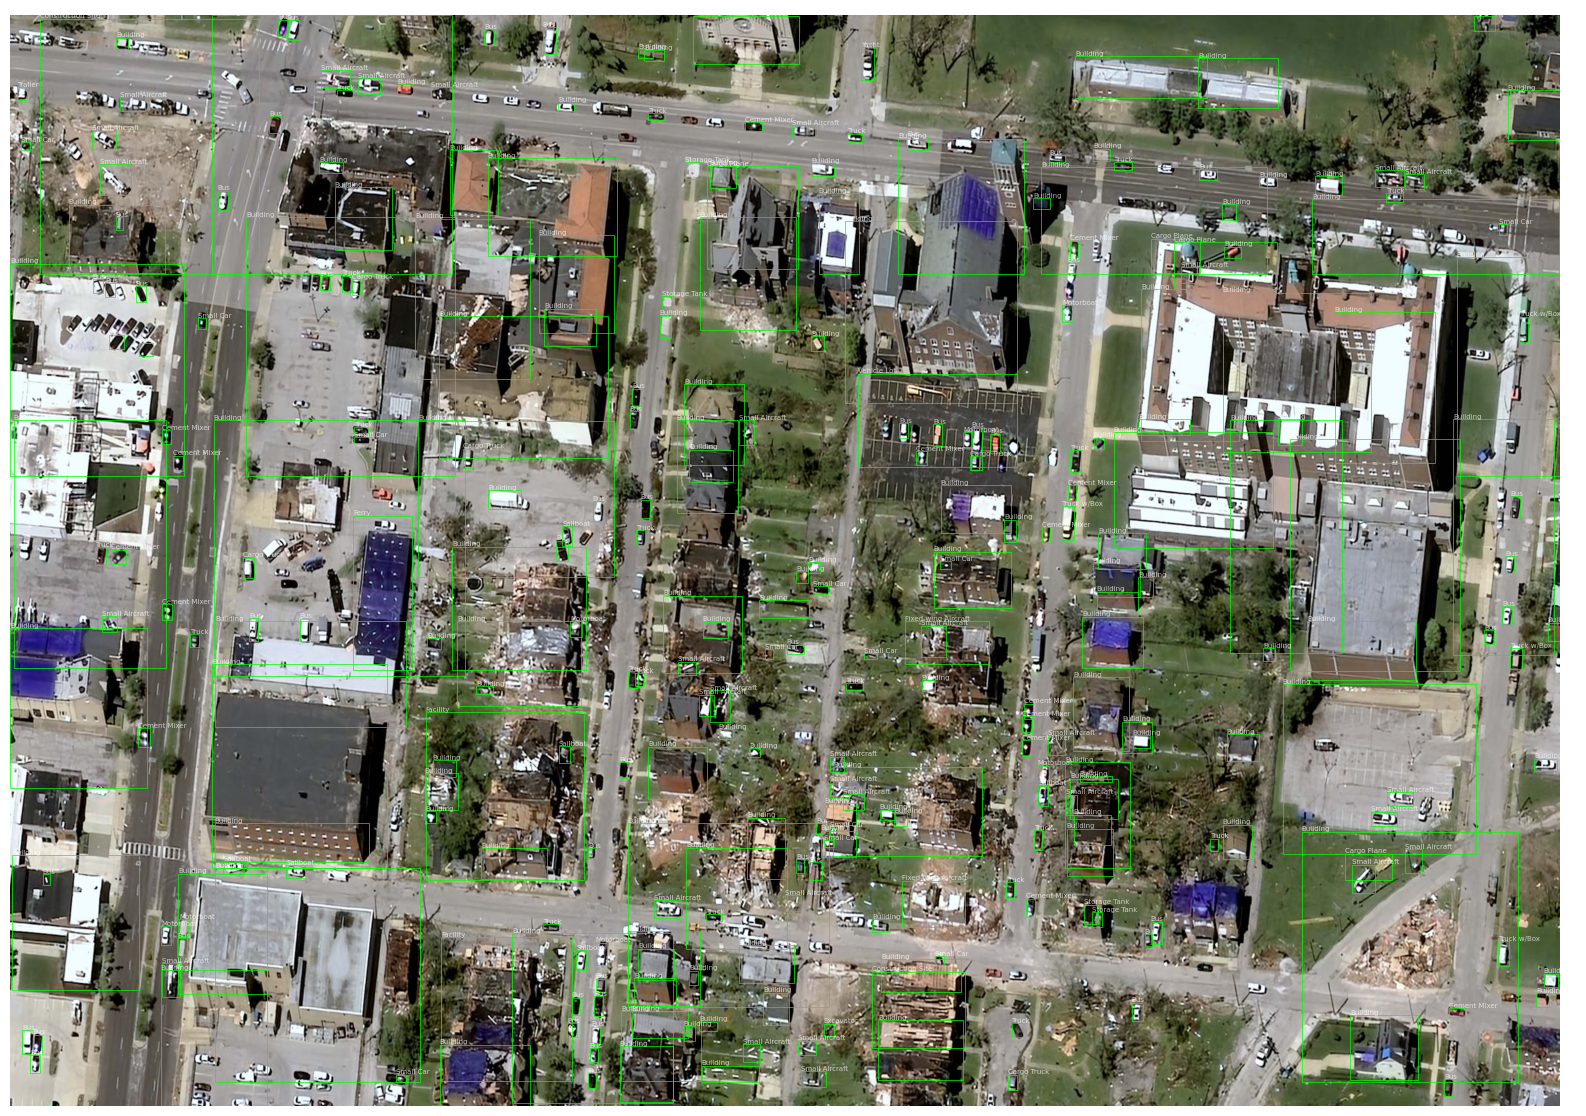

In [32]:

# --- CONFIGURAZIONE PERCORSI ---
full_img_path='/kaggle/input/maradona/Tornado destruction path St Louis USA very-high resolution satellite image.jpg'
OUTPUT_DIR = '/kaggle/working/predictions'
os.makedirs(OUTPUT_DIR, exist_ok=True)


# --- CONFIGURAZIONE TILING INFERENZA ---
TILE_SIZE = 512
STRIDE = 400  # Sovrapposizione di 112px per non tagliare oggetti a metà

# --- DIZIONARIO DEI NOMI ---
ID_TO_NAME = {
    1: 'Fixed-wing Aircraft', 2: 'Small Aircraft', 3: 'Cargo Plane', 4: 'Helicopter',
    5: 'Passenger Vehicle', 6: 'Small Car', 7: 'Bus', 8: 'Pickup Truck',
    9: 'Utility Truck', 10: 'Truck', 11: 'Cargo Truck', 12: 'Truck w/Box',
    13: 'Truck Tractor', 14: 'Trailer', 15: 'Truck w/Flatbed', 16: 'Truck w/Liquid',
    17: 'Crane Truck', 18: 'Railway Vehicle', 19: 'Passenger Car', 20: 'Cargo Car',
    21: 'Flat Car', 22: 'Tank Car', 23: 'Locomotive', 24: 'Maritime Vessel',
    25: 'Motorboat', 26: 'Sailboat', 27: 'Tugboat', 28: 'Barge',
    29: 'Fishing Vessel', 30: 'Ferry', 31: 'Yacht', 32: 'Container Ship',
    33: 'Oil Tanker', 34: 'Engineering Vehicle', 35: 'Tower crane', 36: 'Container Crane',
    37: 'Reach Stacker', 38: 'Straddle Carrier', 39: 'Mobile Crane', 40: 'Dump Truck',
    41: 'Haul Truck', 42: 'Scraper/Tractor', 43: 'Front loader/Bulldozer', 44: 'Excavator',
    45: 'Cement Mixer', 46: 'Ground Grader', 47: 'Hut/Tent', 48: 'Shed',
    49: 'Building', 50: 'Aircraft Hangar', 51: 'Damaged Building', 52: 'Facility',
    53: 'Construction Site', 54: 'Vehicle Lot', 55: 'Helipad', 56: 'Storage Tank', 57: 'Shipping Container Lot',
    58: 'Shipping container', 59: 'Pylon', 60: 'Tower'
}

def run_tiled_inference(model, full_img_path, threshold=0.3): # Threshold un po' più alta per evitare rumore
    

    full_img = cv2.imread(full_img_path)
    if full_img is None: return
    full_img_rgb = cv2.cvtColor(full_img, cv2.COLOR_BGR2RGB)
    
    h_img, w_img, _ = full_img.shape
    
    global_boxes = []
    global_scores = []
    global_labels = []

    model.eval()
    
    print("Inizio scansione a tile...")
    

    y = 0
    while y < h_img:
        x = 0
        while x < w_img:
            # Calcolo coordinate tile
            x2 = min(x + TILE_SIZE, w_img)
            y2 = min(y + TILE_SIZE, h_img)
            x1 = x2 - TILE_SIZE
            y1 = y2 - TILE_SIZE
            
            if x1 < 0: x1 = 0
            if y1 < 0: y1 = 0
            
            tile = full_img_rgb[y1:y2, x1:x2]
            
            tile_tensor = torchvision.transforms.functional.to_tensor(tile).to(device)
            with torch.no_grad():
                prediction = model([tile_tensor])[0]
            

            for box, score, label in zip(prediction['boxes'], prediction['scores'], prediction['labels']):
                if score > threshold:
                    # Sposta coordinate locali -> globali
                    box[0] += x1
                    box[1] += y1
                    box[2] += x1
                    box[3] += y1
                    
                    global_boxes.append(box)
                    global_scores.append(score)
                    global_labels.append(label)
            
            # Avanzamento x
            if x2 == w_img: break # Fine riga
            x += STRIDE
            
        # Avanzamento y
        if y2 == h_img: break # Fine immagine
        y += STRIDE

    if len(global_boxes) == 0:
        print("Nessun oggetto trovato.")
        plt.imshow(full_img_rgb)
        plt.show()
        return

    global_boxes = torch.stack(global_boxes)
    global_scores = torch.stack(global_scores)
    global_labels = torch.stack(global_labels)

    print(f"Box grezzi trovati: {len(global_boxes)}")

    
    keep_indices = torchvision.ops.nms(global_boxes, global_scores, iou_threshold=0.3)
    
    final_boxes = global_boxes[keep_indices]
    final_scores = global_scores[keep_indices]
    final_labels = global_labels[keep_indices]

    print(f"Box finali dopo NMS: {len(final_boxes)}")

    plt.figure(figsize=(20, 20))
    plt.imshow(full_img_rgb)
    ax = plt.gca()
    
    for box, score, label in zip(final_boxes, final_scores, final_labels):
        x1, y1, x2, y2 = box.cpu().numpy()
        class_id = label.item()
        class_name = ID_TO_NAME.get(class_id, f"ID {class_id}")
        
        rect = plt.Rectangle(
            (x1, y1),
            x2 - x1,
            y2 - y1,
            fill=False,
            color='#00FF00',
            linewidth=0.5
        )
        ax.add_patch(rect)
    
        ax.text(
            x1,
            y1 - 2,
            class_name,
            color='white',
            fontsize=5,
            #backgroundcolor='black',
            alpha=0.7
        )
    
    plt.axis('off')
    
    # --- SALVATAGGIO ---
    output_path = os.path.join(
        OUTPUT_DIR
    )
    
    plt.savefig(output_path, bbox_inches='tight', dpi=200)
    print(f"Immagine salvata in: {output_path}")
    
    plt.show()
# Esegui
run_tiled_inference(model, full_img_path, threshold=0.3)